Loading data...

Training data shape: (2000, 21)
Test data shape: (1000, 21)

Preprocessing data...

Training model...

Training Accuracy: 0.9760

Making predictions...

Predictions distribution:
Predicted_Price_Range
0    255
1    252
2    227
3    266
Name: count, dtype: int64

Predictions saved to 'predictions.csv'

Analyzing feature importance...


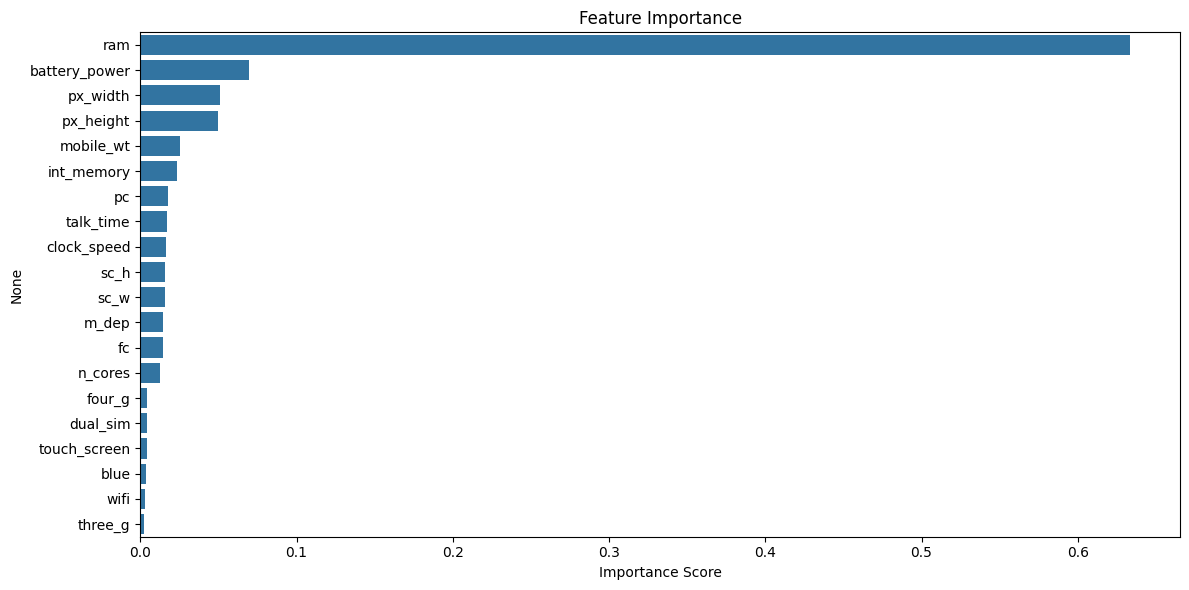


Top 5 Most Important Features:
ram: 0.6337
battery_power: 0.0694
px_width: 0.0511
px_height: 0.0500
mobile_wt: 0.0253
Model and scaler saved successfully!


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def load_data(train_path, test_path):
    """
    Load training and test datasets from separate CSV files
    """
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

def preprocess_data(train_df, test_df):
    """
    Preprocess training and test data separately
    Handles cases where test data doesn't have the target variable
    """
    # Remove ID column if it exists
    if 'id' in train_df.columns:
        train_df = train_df.drop('id', axis=1)
    if 'id' in test_df.columns:
        test_df = test_df.drop('id', axis=1)

    # List of feature columns (excluding price_range and any non-feature columns)
    feature_columns = [
        'battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
        'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
        'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
        'touch_screen', 'wifi'
    ]

    # For training data
    X_train = train_df[feature_columns]
    y_train = train_df['price_range']

    # For test data - check if price_range exists
    X_test = test_df[feature_columns]
    y_test = test_df['price_range'] if 'price_range' in test_df.columns else None

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, feature_columns

def train_model(X_train, y_train):
    """
    Train a Random Forest model with optimized parameters
    """
    rf_model = RandomForestClassifier(
        n_estimators=100,     # Reduced number of trees
        max_depth=8,          # Reduced depth
        min_samples_split=10, # Increased min samples to split
        min_samples_leaf=4,   # Increased min samples per leaf
        max_features='sqrt',  # Restrict features considered at each split
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    return rf_model

def evaluate_model(model, X_test, y_test=None):
    """
    Evaluate model performance and create visualizations if y_test is available
    Otherwise, just make predictions
    """
    y_pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)

    if y_test is not None:
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    # Create predictions DataFrame
    predictions_df = pd.DataFrame({
        'Predicted_Price_Range': y_pred,
        'Confidence': np.max(pred_proba, axis=1)
    })

    # Add probability for each class
    for i in range(len(model.classes_)):
        predictions_df[f'Probability_Class_{i}'] = pred_proba[:, i]

    # Save predictions
    predictions_df.to_csv('predictions.csv', index=False)
    print("\nPredictions distribution:")
    print(predictions_df['Predicted_Price_Range'].value_counts().sort_index())
    print("\nPredictions saved to 'predictions.csv'")

    return predictions_df

def analyze_feature_importance(model, feature_names):
    """
    Analyze and visualize feature importance
    """
    importances = model.feature_importances_
    feature_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=feature_imp.values, y=feature_imp.index)
    plt.title('Feature Importance')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

    print("\nTop 5 Most Important Features:")
    for feature, importance in feature_imp.head().items():
        print(f"{feature}: {importance:.4f}")

def main(train_path, test_path):
    """
    Main function to run the entire pipeline
    """
    # Load the data
    print("Loading data...")
    train_df, test_df = load_data(train_path, test_path)

    print("\nTraining data shape:", train_df.shape)
    print("Test data shape:", test_df.shape)

    # Preprocess the data
    print("\nPreprocessing data...")
    X_train_scaled, X_test_scaled, y_train, y_test, scaler, feature_columns = preprocess_data(train_df, test_df)

    # Train the model
    print("\nTraining model...")
    model = train_model(X_train_scaled, y_train)

    # Print training accuracy
    train_accuracy = model.score(X_train_scaled, y_train)
    print(f"\nTraining Accuracy: {train_accuracy:.4f}")

    # Evaluate the model
    print("\nMaking predictions...")
    predictions_df = evaluate_model(model, X_test_scaled, y_test)

    # Analyze feature importance
    print("\nAnalyzing feature importance...")
    analyze_feature_importance(model, feature_columns)

    return model, scaler, predictions_df

if __name__ == "__main__":

    # Specify your file paths
    train_path = 'train.csv'
    test_path = 'test.csv'

    # Run the main pipeline
    model, scaler, predictions_df = main(train_path, test_path)


    import joblib

# Add this at the end of your main() function, after training the model
def save_model_and_scaler(model, scaler):
    """
    Save the trained model and scaler
    """
    joblib.dump(model, 'mobile_price_model.joblib')
    joblib.dump(scaler, 'scaler.joblib')
    print("Model and scaler saved successfully!")

# In your main function, add:
save_model_and_scaler(model, scaler)